In [35]:
from matplotlib.image import imread
from matplotlib.image import imsave
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from models import skip

In [36]:
np.random.seed(0)
dtype = torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [37]:
img = imread('snail.jpg')

### Standard noise deviation for a dynamic range [0, 255]

In [38]:
sigma = 25.0

### Reshape the image so that it matches with the output of the network (each dimension being a multiple of 4)

In [39]:
img = img[1:257, 8:392] # TODO, generalize

### Corrupt the image

In [40]:
corrupted_img = np.clip(img + np.random.normal(loc=0.0, scale=sigma, size=img.shape), 0, 255.0)/255.0
imsave('corrupted_img.png', corrupted_img)

### Latent space

In [41]:
z = np.random.normal(loc=0.0, scale=sigma/255.0, size=(1,3, 256, 384)) # TODO, generalize shape

### Generative Network

In [42]:
input_depth = 3
pad = 'reflection'
net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')
net.to(device)
net = net.float()
model = net

### Compute the number of parameters

In [43]:
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

Number of params: 572827


In [44]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

### Hyperparameters

In [45]:
epochs = 200
steps = 0
running_loss = 0
print_every = 100

### Denoise the image

In [46]:
training_loss = []
true_MSE = [] # Evolution of MSE with the corrupted image

z = torch.FloatTensor(z)
for epoch in range(epochs):
    steps += 1
    optimizer.zero_grad()
    logps = model.forward(z)
    loss = criterion(logps[0], torch.FloatTensor(corrupted_img.transpose(2,0,1)))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
    training_loss.append(loss.item())
    true_MSE.append(criterion(logps[0], torch.FloatTensor(img.transpose(2,0,1)/255.)))
    
    if steps % print_every == 0:
        with torch.no_grad():

            imsave('denoised_img'+ str(steps) +'.png',logps[0].detach().numpy().transpose(1,2,0))                     
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. ")
            running_loss = 0

Epoch 100/200.. Train loss: 0.052.. 
Epoch 200/200.. Train loss: 0.013.. 


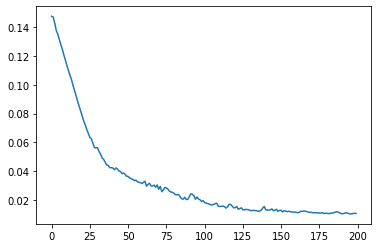

In [47]:
plt.plot(training_loss)

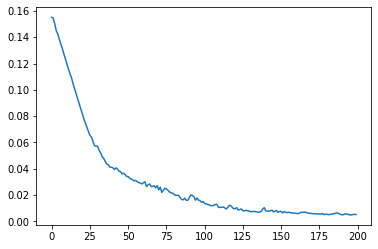

In [48]:
plt.plot(true_MSE)